Note: this includes the code to create the sliding window as well as training TabPFN.



The real training is done in google Colab (for TabPFN, I ended up using XGBoost instead)

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
from elopy import *
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from elopy import Implementation

### 1. Import & set main dataframe
Import dataset, set df as the original reference dataset

Over/under 74.5 points is -120 odds (for players with about even odds). Need to win at least 54.55% of the time to break even at these odds

In [2]:
# Import & drop duplicates for ttElite
dfElite = pd.read_csv('./ttennisData/TTElite.csv')
dfElite = dfElite.drop_duplicates(keep='last')
dfElite.to_csv('./ttennisData/TTElite.csv', index=False)

# Import & drop duplicates for ttCup
df = pd.read_csv("./ttennisData/TTCup.csv")
df = df.drop_duplicates(keep='last')
df.to_csv('./ttennisData/TTCup.csv', index=False)

print(f"{df.shape} {dfElite.shape}")
df = pd.concat([df, dfElite])
print(f"{df.shape}")

/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_9026/2379169345.py:7: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./ttennisData/TTCup.csv")


(122721, 20) (187781, 20)
(310502, 20)


In [3]:
# df = pd.read_csv("./ttennisData/TTCup.csv")
print(df.shape)
df = df.fillna(0) # G4+ have 

# ------- Create new columns -------
# Combine P1 and P2 scores for each game
for i in range(1, 6):
    df[f'G{i}_Total'] = df[f'P1_G{i}'] + df[f'P2_G{i}']

# Player 1 total score from G1 to G5
df['Total_P1'] = df[[f'P1_G{i}' for i in range(1, 6)]].sum(axis=1)
df['Total_Avg_P1'] = df['Total_P1']

# Player 2 total score from G1 to G5
df['Total_P2'] = df[[f'P2_G{i}' for i in range(1, 6)]].sum(axis=1)
df['Total_Avg_P2'] = df['Total_P2']

# Sum of combined scores from G1 to G5
df['Total_Score'] = df[[f'G{i}_Total' for i in range(1, 6)]].sum(axis=1)
df['Over_74'] = df['Total_Score'] > 74
df['G5'] = df['G5_Total'] > 0
df['G4'] = (df['G4_Total'] > 0) & (df['G5_Total'] == 0)
df['G45'] = (df['G4_Total'] > 0) | (df['G5_Total'] > 0)
df['G34'] = (df['G5_Total'] == 0)

for i in range(1,6):
    df.rename(columns={f'P1_G{i}': f'G{i}_P1', f'P2_G{i}': f'G{i}_P2'}, inplace=True)

df.rename(columns={'P1_Total': 'Total_P1', 'P2_Total': 'Total_P2'}, inplace=True)

# df['No_Odds'] = (df['Odds_P1'] + df['Odds_P2'] == 0)
# print(df['No_Odds'].sum())

df['Total_Allowed_P1'] = df['Total_P2']
df['Total_Allowed_P2'] = df['Total_P1']

df['Sets_Allowed_P1'] = df['Sets_P2']
df['Sets_Allowed_P2'] = df['Sets_P1']

df['Win_P1'] = df['Total_P1'] > df['Total_P2']
df['Win_P2'] = df['Total_P2'] > df['Total_P1']

# This is just for bill james pythagoren
#df['G34_P1'] = df['G34']
#df['G34_P2'] = df['G34']

df = df.sort_values(by='Date')
df.info()

(310502, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 310502 entries, 122689 to 187780
Data columns (total 41 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              310502 non-null  float64
 1   Player1           310502 non-null  float64
 2   Player2           310502 non-null  float64
 3   Player1_Name      310502 non-null  object 
 4   Player2_Name      310502 non-null  object 
 5   Sets_P1           310502 non-null  float64
 6   Sets_P2           310502 non-null  float64
 7   Odds_P1           310502 non-null  float64
 8   Odds_P2           310502 non-null  float64
 9   G1_P1             310502 non-null  float64
 10  G1_P2             310502 non-null  float64
 11  G2_P1             310502 non-null  float64
 12  G2_P2             310502 non-null  float64
 13  G3_P1             310502 non-null  float64
 14  G3_P2             310502 non-null  float64
 15  G4_P1             310502 non-null  float64
 16  G4_P2  

In [4]:
df.head()

,Date,Player1,Player2,Player1_Name,Player2_Name,Sets_P1,Sets_P2,Odds_P1,Odds_P2,G1_P1,...,G5,G4,G45,G34,Total_Allowed_P1,Total_Allowed_P2,Sets_Allowed_P1,Sets_Allowed_P2,Win_P1,Win_P2
122689,1.612281e+09,329135.0,360367.0,0,0,2.0,3.0,1.27,3.35,11.0,...,True,False,True,False,50.0,46.0,3.0,2.0,False,True
122688,1.612283e+09,352537.0,328779.0,0,0,1.0,3.0,2.10,1.65,10.0,...,False,True,True,True,38.0,34.0,3.0,1.0,False,True
122687,1.612286e+09,329135.0,352537.0,0,0,3.0,0.0,1.60,2.20,11.0,...,False,False,False,True,14.0,33.0,0.0,3.0,True,False
122686,1.612288e+09,376223.0,360367.0,0,0,0.0,3.0,1.85,1.85,5.0,...,False,False,False,True,33.0,14.0,3.0,0.0,False,True
122685,1.612290e+09,329135.0,376223.0,0,0,1.0,3.0,1.35,2.95,11.0,...,False,True,True,True,42.0,32.0,3.0,1.0,False,True


### Some rows may contain upcoming data, filter these out
Sept 2026

In [5]:
print(df.shape)
print(f"Number of rows containing upcoming data: {df[df["Total_Score"] == 0].shape}")
dfUpcoming = df[df["Total_Score"] == 0]
df = df[df["Total_Score"] != 0]
print(df.shape)
print(dfUpcoming.shape)

(310502, 41)
Number of rows containing upcoming data: (101, 41)
(310401, 41)
(101, 41)


In [6]:
cont_cols = [
    'Date',
    'Player1',
    'Player2',
    'Sets_P1',
    'Sets_P2',

    'G1_P1',
    'G1_P2',
    'G2_P1',
    'G2_P2',
    'G3_P1',
    'G3_P2',
    'G4_P1',
    'G4_P2',
    'G5_P1',
    'G5_P2',

    'Win_P1',
    'Win_P2',

    #'G34_P1',
    #'G34_P2',
    
#    'No_Odds', # Removed from EDA
    'Total_P1', # Unadjusted total for 74.5.. (careful re: leakage)
    'Total_P2', # Unadjusted total for 74.5.. (careful re: leakage)

    'Total_Avg_P1', # Non-leakage of total
    'Total_Avg_P2', # Non-leakage of total
    'Total_Score', # Unadjusted total (careful re: leakage)
    'Total_Allowed_P1',
    'Total_Allowed_P2',
    'Sets_Allowed_P1',
    'Sets_Allowed_P2',
]

track_cols = [
    'Date',
    'Sets',
    'Sets_Allowed',
    'G1',
    'G2',
    'G3',
    'G4',
    'G5',
    
    #'G45',
    #'G34',
    'Win',
    
    'Odds',
    'Total',
    'Total_Avg',
    'Total_Allowed',
]


y_col = ['H_Won']

# Convert columns to int (it originally was int before odds data was added)
for col in cont_cols:
    df[col] = df[col].astype(np.int64)
cont_cols = cont_cols + ['Over_74','G5','G4', 'G34', 'G45', 'Odds_P1','Odds_P2','Player1_Name', 'Player2_Name']

df = df[cont_cols]
df.info()
dfUpcoming = dfUpcoming[cont_cols]

<class 'pandas.core.frame.DataFrame'>
Index: 310401 entries, 122689 to 187709
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              310401 non-null  int64  
 1   Player1           310401 non-null  int64  
 2   Player2           310401 non-null  int64  
 3   Sets_P1           310401 non-null  int64  
 4   Sets_P2           310401 non-null  int64  
 5   G1_P1             310401 non-null  int64  
 6   G1_P2             310401 non-null  int64  
 7   G2_P1             310401 non-null  int64  
 8   G2_P2             310401 non-null  int64  
 9   G3_P1             310401 non-null  int64  
 10  G3_P2             310401 non-null  int64  
 11  G4_P1             310401 non-null  int64  
 12  G4_P2             310401 non-null  int64  
 13  G5_P1             310401 non-null  int64  
 14  G5_P2             310401 non-null  int64  
 15  Win_P1            310401 non-null  int64  
 16  Win_P2            31

# 2. Check and remove missing data
from https://www.kaggle.com/code/gpreda/santander-eda-and-prediction

In [7]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [8]:
pd.set_option('display.max_columns', None)
df.dropna()
missing_data(df)

,Date,Player1,Player2,Sets_P1,Sets_P2,G1_P1,G1_P2,G2_P1,G2_P2,G3_P1,G3_P2,G4_P1,G4_P2,G5_P1,G5_P2,Win_P1,Win_P2,Total_P1,Total_P2,Total_Avg_P1,Total_Avg_P2,Total_Score,Total_Allowed_P1,Total_Allowed_P2,Sets_Allowed_P1,Sets_Allowed_P2,Over_74,G5,G4,G34,G45,Odds_P1,Odds_P2,Player1_Name,Player2_Name
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bool,bool,bool,bool,bool,float64,float64,object,object


### 2. Create a dict to track the track_cols array
create another dict to track previous games for each team during the year

In [9]:
track_dict = {}
elopy = Implementation()

def addToTrackDict(column_name, value):
    """
    Adds value to track_dict. Handles cases where it doesn't exist
    """
    if column_name in track_dict:
        track_dict[column_name].append(value)
    else:
        track_dict[column_name] = [value]
        

for row in df.itertuples():
    year = datetime.fromtimestamp(row.Date).year # row.Date.split('-')[0]
    # year = row.Season
    home_team = row.Player1
    visitor_team = row.Player2

    # ELO calculation
    if not elopy.contains(home_team):
        elopy.addPlayer(home_team)
    if not elopy.contains(visitor_team):
        elopy.addPlayer(visitor_team)
    winning_team = home_team if getattr(row, 'Win_P1') == 1 else visitor_team
    elopy.recordMatch(home_team, visitor_team, winner=winning_team)
    addToTrackDict(f'{year}_{home_team}_elo', elopy.getPlayerRating(home_team))
    addToTrackDict(f'{year}_{visitor_team}_elo', elopy.getPlayerRating(visitor_team))
    
    # Home or visitor team has < minimum_window total games
    for col in track_cols:
        if col in ['elo']:
            continue
        home_column_name = f'{year}_{home_team}_{col}'
        visitor_column_name = f'{year}_{visitor_team}_{col}'
        
        # Home team
        home_col = col if col == 'Date' else col + '_P1'
        addToTrackDict(home_column_name, getattr(row, home_col))
        
        # Visitor team
        visitor_col = col if col == 'Date' else col + '_P2'
        addToTrackDict(visitor_column_name, getattr(row, visitor_col))

    
        

## 2a. Calculate the optimal exponent for points/sets pythagorean expectation
From https://copilot.microsoft.com/chats/F2gCDvCuGxG8hWmyky6w1

In [10]:
# track_dict.keys()

### 3. Use track_dict to enforce minimum_window, update df or drop row


In [11]:
print(df.shape)
print(dfUpcoming.shape)
# df = df[:30000]

(310401, 35)
(101, 35)


In [12]:
def get_optimal_exponent(x_for, x_against, win_pct):
    """
    For calculating the optimal exponent in pythagorean expecatation
    
    x_for: np.array up to & not including the current game
    x_against: np.array up to & not including the current game
    win_pct: win pct array
    
    with x being home_pts or score

    Maybe use margin based scaling 
    https://chatgpt.com/c/68f81378-7ddc-8326-907c-10ed768953e3
    
    """
    eps = 1e-6
    # Clip win_pct away from 0/1 to avoid degenerate residuals
    win_pct = np.clip(win_pct, eps, 1 - eps)

    window = 5
    win_pct = np.convolve(win_pct, np.ones(window)/window, mode='valid')
    x_for = x_for[-len(win_pct):]
    x_against = x_against[-len(win_pct):]

    # Ensure strictly positive values before taking logs
    logf = np.log(x_for + eps)
    loga = np.log(x_against + eps)
    
    def pythagorean_expectation(inputs, exponent):
        lf, la = inputs
        z = exponent * (la-lf)
        # clip z to avoid exp overflow; exp(700) ~ 1e304, safe upper bound for float64
        z = np.clip(z, -700, 700)
        return 1.0 / (1.0 + np.exp(z))
        
    params, _ = curve_fit(pythagorean_expectation, (logf, loga), win_pct,
                          p0=1.83, bounds=(0.1,10), maxfev=20000)
    return params[0] # optimal exponent

In [13]:
def calcStartEndIdx(date_index, max_window):
    """
    date_index: home_date_index or visitor_date_index. Basically the index of the current record

    RETURNS:
        start_index: The index that goes as far back as max_window (or 0 if < array length) 
        end_index: The index right before the current record
    """
    end_index = date_index - 1
    start_index = max(end_index - max_window, 0)
    return (start_index, end_index)

In [14]:
def createCsv(df, minimum_window, max_window, ema_span):
    """
    df: instance of dataframe (edits in place, keep an original 'before' copy outside of this
    minimum_window: minimum number of records to get the average of
    max_window: The maximum number of records to get the average of
    ema_span: the exponential moving average span.
    """
    indices_to_drop = []
    current_count = 0
    for row in df.itertuples():
        if current_count % 500 == 0:
            print(f'{current_count}/{df.shape[0]}')
        current_count = current_count + 1
        index = row.Index
        year = datetime.fromtimestamp(row.Date).year # row.Date.split('-')[0]
        # year = row.Season
        home_team = int(row.Player1)
        visitor_team = int(row.Player2)
        # Home team min window
        home_date_column = f'{year}_{home_team}_Date'
        visitor_date_column = f'{year}_{visitor_team}_Date'
    
        # Drop indice if not enough data
        if len(track_dict[home_date_column]) <= minimum_window or len(track_dict[visitor_date_column]) <= minimum_window:
            indices_to_drop.append(index)
            continue
    
        # Current row is older than Home team at min_window
        if row.Date <= track_dict[home_date_column][minimum_window]:
            indices_to_drop.append(index)
            continue
        # Current row is older than Visitor team at min_window
        if row.Date <= track_dict[visitor_date_column][minimum_window]:
            indices_to_drop.append(index)
            continue
    
        home_date_index = track_dict[home_date_column].index(int(row.Date))
        visitor_date_index = track_dict[visitor_date_column].index(int(row.Date))
        # print(f'H: {home_date_index} V: {visitor_date_index}')
    
        # print("----- Track Cols -----")
        # Update df to have average for each track_cols (Ignoring 'Date', the 1-2nd item)
        for col in track_cols:
            if col in ['Date', 'Odds', 'Total']:
                continue
            else:
                # print(col)
                # Convert to float
                if df.dtypes[col + '_P1'] == 'int64' or df.dtypes[col + '_P2'] == 'int64':
                    df = df.astype({f'{col}_P1': 'float64', f'{col}_P2': 'float64'})
                # Update df to have average for each track_cols (Ignoring 'Date', .. items)
                # Update home
    
                start, end = calcStartEndIdx(home_date_index, max_window)
                home_col_list = track_dict[f'{year}_{home_team}_{col}'][start:end]
                dataframe_val = pd.DataFrame({'value': home_col_list})
                ema = dataframe_val['value'].ewm(span=min(ema_span, len(home_col_list)), adjust=True).mean().iloc[-1]
                df.at[index, col + '_P1'] = ema

                # Update Visitor
                start, end = calcStartEndIdx(visitor_date_index, max_window)
                visitor_col_list = track_dict[f'{year}_{visitor_team}_{col}'][start:end]
                dataframe_val = pd.DataFrame({'value': visitor_col_list})
                ema = dataframe_val['value'].ewm(span=min(ema_span, len(visitor_col_list)), adjust=True).mean().iloc[-1]
                df.at[index, col + '_P2'] = ema
    
    
        # --------------------------------------------------- 
        # ------------------ Custom Columns -----------------
        # --------------------------------------------------- 
        
        # 1. Add variant of Bill James pythagorean expectation (NFL).
        # 1a. For total points (pythagorean P1, pythagorean P2)
        # Recent games weighted more heavily since 'Final' columns not excluded from the above loop
        start, end = calcStartEndIdx(home_date_index, max_window)
        home_points_for = np.array(track_dict[f'{year}_{home_team}_Total'][start:end])
        home_points_against = np.array(track_dict[f'{year}_{home_team}_Total_Allowed'][start:end])
        home_win_pct = track_dict[f'{year}_{home_team}_Win'][start:end]
        optimal_exp = get_optimal_exponent(home_points_for, home_points_against, home_win_pct)
        home_points_for = sum(home_points_for)
        home_points_against = sum(home_points_against)
        df.at[index, 'pythagorean_P1'] = home_points_for**optimal_exp / (home_points_for**optimal_exp + home_points_against**optimal_exp)

        start, end = calcStartEndIdx(visitor_date_index, max_window)
        visitor_points_for = np.array(track_dict[f'{year}_{visitor_team}_Total'][start:end])
        visitor_points_against = np.array(track_dict[f'{year}_{visitor_team}_Total_Allowed'][start:end])
        visitor_win_pct = np.array(track_dict[f'{year}_{visitor_team}_Win'][start:end])
        optimal_exp = get_optimal_exponent(visitor_points_for, visitor_points_against, visitor_win_pct)
        visitor_points_for = sum(visitor_points_for)
        visitor_points_against = sum(visitor_points_against)
        df.at[index, 'pythagorean_P2'] = visitor_points_for**optimal_exp / (visitor_points_for**optimal_exp + visitor_points_against**optimal_exp)
    
        # 2. Add ELO for home, away
        df.at[index, 'elo_P1'] = track_dict[f'{year}_{home_team}_elo'][home_date_index-1]
        df.at[index, 'elo_P2'] = track_dict[f'{year}_{visitor_team}_elo'][visitor_date_index-1]
        
    """
        # 1b. For total number of sets (pythagorean_sets_P1, pythagorean_sets_P2)
        home_sets_for = np.array(track_dict[f'{year}_{home_team}_Sets'][:home_date_index-1])
        home_sets_against = np.array(track_dict[f'{year}_{home_team}_Sets_Allowed'][:home_date_index-1])
        home_34_sets = np.array(track_dict[f'{year}_{home_team}_G34'][:home_date_index-1])
        feature, optimal_exp = get_G34_feature(home_sets_for, home_sets_against, home_34_sets)
        home_sets_for = sum(home_sets_for)
        home_sets_against = sum(home_sets_against)
        
        print(f"Optimal exponent: {optimal_exp:.4f}")
        df.at[index, 'pythagorean_sets_P1'] = home_sets_for**optimal_exp / (home_sets_for**optimal_exp + home_sets_against**optimal_exp)
    
        visitor_sets_for = sum(track_dict[f'{year}_{visitor_team}_Sets'][:visitor_date_index-1])
        visitor_sets_against = sum(track_dict[f'{year}_{visitor_team}_Sets_Allowed'][:visitor_date_index-1])
        df.at[index, 'pythagorean_sets_P2'] = visitor_sets_for**1.83 / (visitor_sets_for**1.83 + visitor_sets_against**1.83)
    """
    
    df.drop(indices_to_drop, inplace=True)
    
    # Add custom metrics to track_cols so it creates the difference (D_) column
    # track_cols.append('pythagorean')
    for col in track_cols[1:]:
        cont_cols.append('D_' + col)
        df['D_' + col] = (df[col + '_P1'] - df[col + '_P2']).round(3) # Round to 3 sig figs
        
    # Remove columns that begin with H_ or V_ in df
    # y_col = ['H_Won', 'H_start_odds', 'V_start_odds']
    y_col = ['H_start_odds', 'V_start_odds']
    df = df.loc[:, ~(df.columns.str.startswith(('H_', 'V_')) & (~df.columns.isin(y_col)))]
    
    
    df['Over_74'] = df['Over_74'].astype(np.int64)
    df['G5'] = df['G5'].astype(np.int64)
    df['G4'] = df['G4'].astype(np.int64)
    df['G34'] = df['G34'].astype(np.int64)
    df['G45'] = df['G45'].astype(np.int64)
    
    # df.to_csv(f'./ttennisData/gen/TTCupSliding{minimum_window}_{max_window}_{ema_span}.csv')

min_window_range = [10]
# max_window_range = [20,30,50,100]
# max_window_range = [500, 800]
max_window_range = [100]
# ema_span_range = [5, 10, 15, 20, 30]
# ema_span_range = [20, 30, 50]
ema_span_range = [15, 30]

dfOriginal = df # For
# dfOriginal = dfUpcoming
# df = dfUpcoming
for min_item in min_window_range:
    for max_item in max_window_range:
        for ema_item in ema_span_range:
            createCsv(df, min_item, max_item, ema_item)
            df = dfOriginal




0/310401
500/310401
1000/310401
1500/310401
2000/310401
2500/310401
3000/310401
3500/310401
4000/310401
4500/310401
5000/310401
5500/310401
6000/310401
6500/310401
7000/310401
7500/310401
8000/310401
8500/310401
9000/310401
9500/310401
10000/310401
10500/310401
11000/310401
11500/310401
12000/310401
12500/310401
13000/310401
13500/310401
14000/310401
14500/310401
15000/310401
15500/310401
16000/310401
16500/310401
17000/310401
17500/310401
18000/310401
18500/310401
19000/310401
19500/310401
20000/310401
20500/310401
21000/310401
21500/310401
22000/310401
22500/310401
23000/310401
23500/310401
24000/310401
24500/310401
25000/310401
25500/310401
26000/310401
26500/310401
27000/310401
27500/310401
28000/310401
28500/310401
29000/310401
29500/310401
30000/310401
30500/310401
31000/310401
31500/310401
32000/310401
32500/310401
33000/310401
33500/310401
34000/310401
34500/310401
35000/310401
35500/310401
36000/310401
36500/310401
37000/310401
37500/310401
38000/310401
38500/310401
39000/3104

In [15]:
df.head()

,Date,Player1,Player2,Sets_P1,Sets_P2,G1_P1,G1_P2,G2_P1,G2_P2,G3_P1,G3_P2,G4_P1,G4_P2,G5_P1,G5_P2,Win_P1,Win_P2,Total_P1,Total_P2,Total_Avg_P1,Total_Avg_P2,Total_Score,Total_Allowed_P1,Total_Allowed_P2,Sets_Allowed_P1,Sets_Allowed_P2,Over_74,G5,G4,G34,G45,Odds_P1,Odds_P2,Player1_Name,Player2_Name
122689,1612281300,329135,360367,2,3,11,9,11,7,6,11,8,11,10,12,0,1,46,50,46,50,96,50,46,3,2,True,True,False,False,True,1.27,3.35,0,0
122688,1612283400,352537,328779,1,3,10,12,6,11,11,4,7,11,0,0,0,1,34,38,34,38,72,38,34,3,1,False,False,True,True,True,2.10,1.65,0,0
122687,1612285500,329135,352537,3,0,11,8,11,4,11,2,0,0,0,0,1,0,33,14,33,14,47,14,33,0,3,False,False,False,True,False,1.60,2.20,0,0
122686,1612287600,376223,360367,0,3,5,11,1,11,8,11,0,0,0,0,0,1,14,33,14,33,47,33,14,3,0,False,False,False,True,False,1.85,1.85,0,0
122685,1612289700,329135,376223,1,3,11,9,4,11,9,11,8,11,0,0,0,1,32,42,32,42,74,42,32,3,1,False,False,True,True,True,1.35,2.95,0,0


In [16]:
# print(df.info())
df['Over_74'] = df['Over_74'].astype(np.int64)
df['G5'] = df['G5'].astype(np.int64)
df['G4'] = df['G4'].astype(np.int64)
df['G34'] = df['G34'].astype(np.int64)
df['G45'] = df['G45'].astype(np.int64)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 310401 entries, 122689 to 187709
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              310401 non-null  int64  
 1   Player1           310401 non-null  int64  
 2   Player2           310401 non-null  int64  
 3   Sets_P1           310401 non-null  int64  
 4   Sets_P2           310401 non-null  int64  
 5   G1_P1             310401 non-null  int64  
 6   G1_P2             310401 non-null  int64  
 7   G2_P1             310401 non-null  int64  
 8   G2_P2             310401 non-null  int64  
 9   G3_P1             310401 non-null  int64  
 10  G3_P2             310401 non-null  int64  
 11  G4_P1             310401 non-null  int64  
 12  G4_P2             310401 non-null  int64  
 13  G5_P1             310401 non-null  int64  
 14  G5_P2             310401 non-null  int64  
 15  Win_P1            310401 non-null  int64  
 16  Win_P2            31

In [33]:
df.to_csv(f'./ttennisData/TTCupSliding{minimum_window}.csv')

## Continue for Core ML
- Split into train, test, validation
- Training set, if using G5 or G4, will be upsampled or downsampled

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.05, shuffle=False)
X_test, X_validation = train_test_split(X_test, test_size=0.1, shuffle=False)
y_train = X_train['G5']

rus = RandomUnderSampler(random_state=0)
print(f"BEFORE X_train: {X_train.shape}")
# conts_train, y_col = SMOTE().fit_resample(conts_train, y_col)
X_train, y_train = rus.fit_resample(X_train, y_train)
print(f"AFTER conts_train: {X_train.shape}")

# Write to CSV file
X_train.to_csv(f'./ttennisData/CoreMLTrainTTCupSliding{minimum_window}.csv')
X_test.to_csv(f'./ttennisData/CoreMLTestTTCupSliding{minimum_window}.csv')
X_validation.to_csv(f'./ttennisData/CoreMLValidationTTCupSliding{minimum_window}.csv')

# EDA
### ARFS and feature selection

In [37]:
import arfs
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import arfs.feature_selection as arfsfs
from arfs.feature_selection import GrootCV
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
import arfs.feature_selection.allrelevant as arfsgroot
from ydata_profiling import ProfileReport
from lightgbm import LGBMClassifier
from sklearn.base import clone
rng = np.random.RandomState(seed=42)


In [38]:
df = pd.read_csv(f'./ttennisData/TTCupSliding50.csv')
df.info()
df['H_won'] = df['Total_P1'] > df['Total_P2']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80706 entries, 0 to 80705
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        80706 non-null  int64  
 1   Date              80706 non-null  int64  
 2   Player1           80706 non-null  int64  
 3   Player2           80706 non-null  int64  
 4   Sets_P1           80706 non-null  float64
 5   Sets_P2           80706 non-null  float64
 6   G1_P1             80706 non-null  float64
 7   G1_P2             80706 non-null  float64
 8   G2_P1             80706 non-null  float64
 9   G2_P2             80706 non-null  float64
 10  G3_P1             80706 non-null  float64
 11  G3_P2             80706 non-null  float64
 12  G4_P1             80706 non-null  float64
 13  G4_P2             80706 non-null  float64
 14  G5_P1             80706 non-null  float64
 15  G5_P2             80706 non-null  float64
 16  Win_P1            80706 non-null  float6

(80706, 29)
(80706,)


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	13
Tentative: 	8
Rejected: 	8
All relevant predictors selected in 00:00:04.91
The selected features: ['Sets_P2' 'D_G1' 'D_G2' 'G3_P2' 'D_G3' 'Win_P1' 'Win_P2' 'pythagorean_P1'
 'pythagorean_P2' 'elo_P1' 'elo_P2' 'Total_Allowed_P1' 'Sets_Allowed_P2']
The agnostic ranking: [ 2  1  4  2  1  7  2  1  3  1  1  7  6 10  2  2  9  1  1  1  1  1  1  4
  2  1  2  2  1]
The naive ranking: ['pythagorean_P1', 'pythagorean_P2', 'elo_P2', 'elo_P1', 'D_G3', 'D_G1', 'Sets_P2', 'Win_P1', 'Total_Allowed_P1', 'D_G2', 'Win_P2', 'G3_P2', 'Sets_Allowed_P2', 'Sets_Allowed_P1', 'G2_P2', 'Total_Allowed_P2', 'Sets_P1', 'G5_P1', 'G5_P2', 'Total_Avg_P2', 'G1_P2', 'G1_P1', 'G3_P1', 'G4_P2', 'G4_P1', 'G2_P1', 'Total_Avg_P1', 'D_G5', 'D_G4']


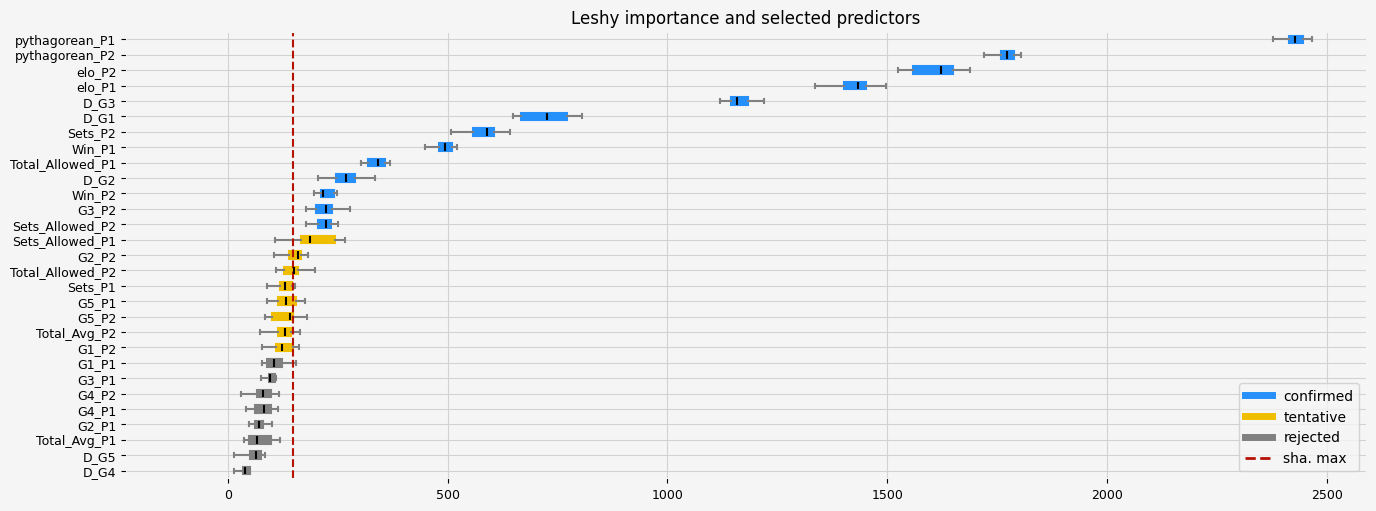

In [39]:
# Load data
x_col = [
    # 'Date',
    # 'Player1',
    # 'Player2',
    'Sets_P1',
    'Sets_P2',

    'G1_P1',
    'G1_P2',
    'D_G1',
    'G2_P1',
    'G2_P2',
    'D_G2',
    'G3_P1',
    'G3_P2',
    'D_G3',
    'G4_P1',
    'G4_P2',
    'D_G4',
    'G5_P1',
    'G5_P2',
    'D_G5',

    'Win_P1',
    'Win_P2',

    #'G34_P1',
    #'G34_P2',
    
#    'No_Odds', # Removed from EDA
#    'Total_P1', # Unadjusted total (careful re: leakage)
#    'Total_P2', # Unadjusted total (careful re: leakage)
#    'Total_Score', # Unadjusted total (careful re: leakage)

    'pythagorean_P1',
    'pythagorean_P2',
    'elo_P1',
    'elo_P2',
    'Total_Avg_P1',
    'Total_Avg_P2',
    
    'Total_Allowed_P1',
    'Total_Allowed_P2',
    'Sets_Allowed_P1',
    'Sets_Allowed_P2',
    'D_Odds'
]


y_col = ['Over_74']
X = df[x_col]
y = df['Over_74']
y = df['G5']
y = df['H_won']

print(X.shape)
print(y.shape)

model = LGBMClassifier(random_state=42, verbose=-1)
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/arfs/feature_selection/allrelevant.py:1556: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/sha

The selected features: ['Sets_P2' 'G1_P1' 'D_G1' 'G2_P1' 'D_G3' 'G5_P2' 'Win_P1' 'pythagorean_P1'
 'pythagorean_P2' 'elo_P1' 'elo_P2' 'Total_Avg_P2' 'Total_Allowed_P1'
 'Total_Allowed_P2' 'Sets_Allowed_P1']
The agnostic ranking: [1 2 2 1 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 2 2 1 2 2 2 2 1]
The naive ranking: ['elo_P2', 'elo_P1', 'pythagorean_P1', 'D_G3', 'pythagorean_P2', 'Total_Allowed_P1', 'Win_P1', 'Sets_P2', 'D_G1', 'Total_Allowed_P2', 'G5_P2', 'G1_P1', 'Total_Avg_P2', 'Sets_Allowed_P1', 'G2_P1', 'D_G2', 'G5_P1', 'Win_P2', 'G1_P2', 'G4_P1', 'G3_P2', 'G2_P2', 'Sets_P1', 'G4_P2', 'Sets_Allowed_P2', 'G3_P1', 'Total_Avg_P1', 'D_G5', 'D_G4']


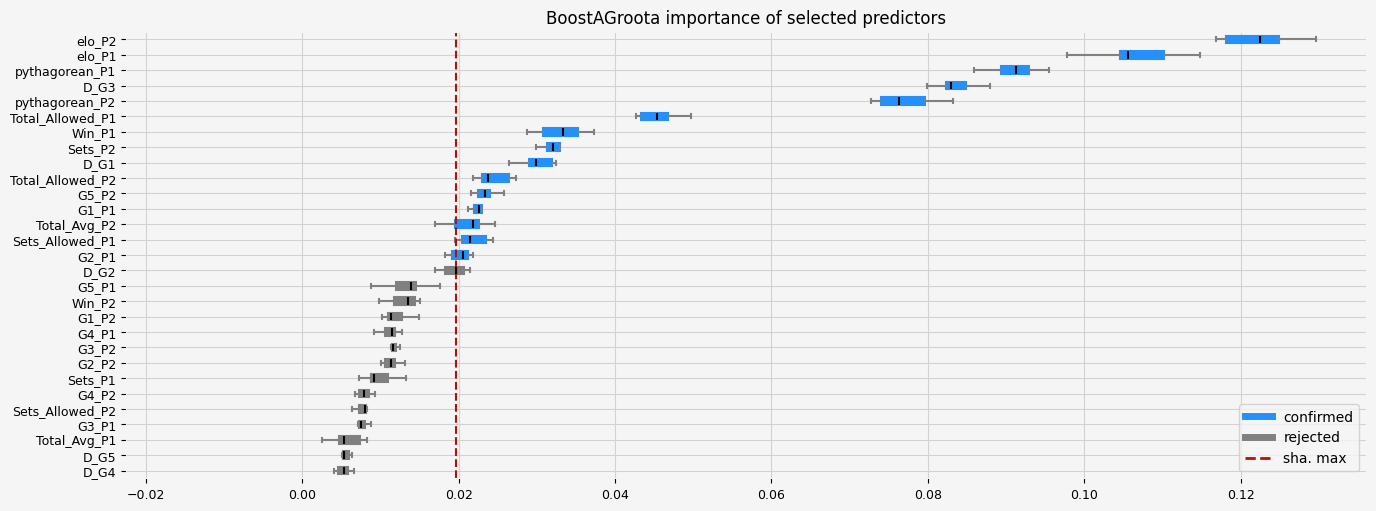

In [40]:
# be sure to use the same but non-fitted estimator
model = LGBMClassifier(random_state=42, verbose=-1)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model,
    cutoff=1,
    iters=10,
    max_rounds=10,
    delta=0.1,
    silent=True,
    importance="fastshap",
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

# Ablation study
Search through the multiple versions of your dataset with different EMA windows (e.g. 10, 20, 30, 50, 75, 100 games)—and train a minimal baseline model on each version. Find best basel

In [4]:
def objective(df, x_col, y_col):
    """
    When doing optuna training: trial is defined, override_params left as None
    when recreating model using best parameters (override_params): trial is None, override_params are defined
    
    df: instance of current pandas df
    x_col: list of the valid x_col 
    y_col: string value of the column name that is being predicted
    """
    # Fixed: Properly extract 1D target array and 2D feature array
    # Use float32 to reduce memory usage (halves memory compared to float64)
    y_prediction = y_col
    y_train = df[y_col].values.astype(np.float32)
    y_col = y_train
    conts_train = np.stack([df[col].values.astype(np.float32) for col in x_col], 1)
    del df
    
    params = { }
    if y_prediction == 'G5':
        params["scale_pos_weight"] = 2.3
    if y_prediction == 'G45':
        params["scale_pos_weight"] = 0.48 # 67.7% of the time
    
    print(params)
    # For imbalanced datasets (IGNORED BECAUSE OF SMOTE)
    #if y_prediction == 'G5' or y_prediction == 'G4':
    #    scale_weight = sum(y_col == 0) / sum(y_col == 1)
    #    params['scale_pos_weight'] = scale_weight[0] # Under X games / At X games
    
    # Training set to fit XGB
    # Test set to fit Calibrator
    # Holdout set (from test set) to calculate loss
    loss = []
    kf = KFold(n_splits=10, shuffle=False)
    for train_index, test_index in kf.split(conts_train):
        X_clas = conts_train[train_index]
        X_cal = conts_train[test_index]

        y_clas = y_col[train_index].ravel() # ravel=flatten to (n,)
        y_cal = y_col[test_index].ravel()
        
        X_cal, X_holdout, y_cal, y_holdout = train_test_split(X_cal, y_cal, test_size=0.1, shuffle=False)
        # Split a val set from X_clas for early stopping (time-aware)
        X_clas, X_clas_eval, y_clas, y_clas_eval = train_test_split(X_clas, y_clas, test_size=0.1, shuffle=False)

        # Create classifier & fit on test set
        classifier = XGBClassifier(
            objective='binary:logistic',
            # eval_metric='error', # UNCOMMENT FOR Over/Under 74.5
            tree_method='hist',
            max_bin=128,
            n_estimators=10,
            verbosity=0,
            eval_metric='error',
            early_stopping_rounds=20,
            n_jobs=2,
            **{k: v for k, v in params.items() if k.startswith('other_') == False}
        )
        # sample_weight = compute_sample_weight('balanced', y_clas)
        #print(f"sample_weight ${sample_weight}")
        classifier.fit(
            X_clas, y_clas,
            #sample_weight=sample_weight,
            eval_set=[(X_clas_eval, y_clas_eval)],
            verbose=False
        )
        
        # Create calibrator (Note: Ideal to have 5k+ records)
        calibrator = IsotonicRegression(out_of_bounds='clip')
        X_cal = classifier.predict_proba(X_cal)[:,1] # has to be 1D to match y_test
        calibrator.fit(X_cal, y_cal)

        # Use holdout set to calculate loss
        X_holdout = classifier.predict_proba(X_holdout)[:,1]
        X_holdout = calibrator.predict(X_holdout)

        # Use AUC-PR if G5 or G4
        holdout_loss = log_loss(y_holdout, X_holdout)
        # holdout_loss = calc_profit(y_holdout, X_holdout)
        
        # if y_prediction == 'G5' or y_prediction == 'G4':
        #    holdout_loss = average_precision_score(y_holdout, X_holdout)
        if y_prediction == 'G5':
            pred_mask = X_holdout > 0.27
            pred_rate = pred_mask.mean()
            MIN_RATE = 0.10
            if pred_mask.sum() == 0 or pred_rate < MIN_RATE:
                loss.append(1e6)
            else:
                loss.append(-y_holdout[pred_mask].mean()) # negative because Optuna minimizes

            # Only compute loss if both arrays are non-empty
            #if perf_y_col_calibrated.shape[0] > 0 and perf_y_eval.shape[0] > 0:
            #    loss.append(accuracy_score(perf_y_col_calibrated, perf_y_eval))
        else:
            loss.append(holdout_loss)

    # CRITICAL: Force cleanup
    del y_train, conts_train
    gc.collect()                          # Python GC
    return np.mean(loss)    

def featureSelection(df, y_prediction):
    """
    This function runs leshy importance to a provided df for a particular y_prediction. 
    It will return an array containing both confirmed and tentative features
    
    df: instance of the pandas dataframe for the current file
    y_prediction: The 
    Returns: a list of confirmed and tentative features
    """
    # Load data
    x_col = [
        # 'Date',
        # 'Player1',
        # 'Player2',
        'Sets_P1',
        'Sets_P2',
    
        'G1_P1',
        'G1_P2',
        'D_G1',
        'G2_P1',
        'G2_P2',
        'D_G2',
        'G3_P1',
        'G3_P2',
        'D_G3',
        'G4_P1',
        'G4_P2',
        'D_G4',
        'G5_P1',
        'G5_P2',
        'D_G5',
    
        'Win_P1',
        'Win_P2',
    
        #'G34_P1',
        #'G34_P2',
        
    #    'No_Odds', # Removed from EDA
    #    'Total_P1', # Unadjusted total (careful re: leakage)
    #    'Total_P2', # Unadjusted total (careful re: leakage)
    #    'Total_Score', # Unadjusted total (careful re: leakage)
    
        'pythagorean_P1',
        'pythagorean_P2',
        'elo_P1',
        'elo_P2',
        'Total_Avg_P1',
        'Total_Avg_P2',
        
        'Total_Allowed_P1',
        'Total_Allowed_P2',
        'Sets_Allowed_P1',
        'Sets_Allowed_P2',
        'D_Odds'
    ]
    
    X = df[x_col]
    y = df[y_prediction]    
    model = LGBMClassifier(random_state=42, verbose=-1)
    feat_selector = arfsgroot.Leshy(
        model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
    )
    feat_selector.fit(X, y, sample_weight=None)
    confirmed_list = X.columns[feat_selector.support_].tolist()
    tentative_list = X.columns[feat_selector.support_weak_].tolist()
    res = confirmed_list + tentative_list
    return res

    

In [5]:
import glob
import arfs
import os
import gc
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.isotonic import IsotonicRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import arfs.feature_selection as arfsfs
from arfs.feature_selection import GrootCV
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
import arfs.feature_selection.allrelevant as arfsgroot
from ydata_profiling import ProfileReport
from sklearn.metrics import accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.base import clone
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict
rng = np.random.RandomState(seed=42)
os.environ["XGBOOST_NUM_THREADS"] = "2"        # limit threads
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"

genFiles = glob.glob('./ttennisData/gen/*.csv')
y_col = 'G45'
performanceArray = []
bestFile = ''
bestXCol = ''
for file in genFiles:
    print(f"{file}")
    df = pd.read_csv(file)
    df['H_won'] = df['Total_P1'] > df['Total_P2']
    # Perform Leshy importance to find best x_col
    x_col = featureSelection(df, y_col)
    print(f"x_col: {x_col}")
    performance = objective(df, x_col, y_col)
    if len(performanceArray) == 0:
        bestFile = file
        bestXCol = x_col        
    elif (y_col != 'fG5' and performance < min(performanceArray)) or performance > max(performanceArray):
        bestFile = file
        bestXCol = x_col
    print(bestFile)
    performanceArray.append(performance)
    print(f"performance: {performance}")




./ttennisData/gen/TTCupSliding10_50_30.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	7
Rejected: 	12
All relevant predictors selected in 00:00:14.51
x_col: ['G4_P1', 'G4_P2', 'G5_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'Sets_Allowed_P1', 'D_Odds', 'D_G1', 'G2_P2', 'G3_P1', 'G3_P2', 'G5_P1', 'pythagorean_P1', 'pythagorean_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_30.csv
performance: 0.618594052905922
./ttennisData/gen/TTCupSliding10_20_5.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	2
Rejected: 	18
All relevant predictors selected in 00:00:14.05
x_col: ['G2_P1', 'G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'pythagorean_P1', 'pythagorean_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_20_5.csv
performance: 0.6206318415629445
./ttennisData/gen/TTCupSliding10_100_20.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	5
Rejected: 	16
All relevant predictors selected in 00:00:16.69
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'Sets_P1', 'G2_P2', 'G3_P2', 'pythagorean_P1', 'Sets_Allowed_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_20_5.csv
performance: 0.6189037888107928
./ttennisData/gen/TTCupSliding10_500_10.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	2
Rejected: 	18
All relevant predictors selected in 00:00:14.26
x_col: ['G4_P1', 'G4_P2', 'pythagorean_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G5_P2', 'Sets_Allowed_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_20_5.csv
performance: 0.6201305856381448
./ttennisData/gen/TTCupSliding10_100_30.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	5
Rejected: 	14
All relevant predictors selected in 00:00:14.61
x_col: ['G3_P1', 'G4_P1', 'G4_P2', 'G5_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'D_G1', 'G3_P2', 'G5_P1', 'pythagorean_P2', 'Sets_Allowed_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_20_5.csv
performance: 0.6186014905674104
./ttennisData/gen/TTCupSliding10_50_20.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	8
Rejected: 	13
All relevant predictors selected in 00:00:14.33
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'Sets_P1', 'G1_P2', 'D_G1', 'G2_P2', 'G3_P1', 'G3_P2', 'G5_P2', 'Win_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6215551506067609
./ttennisData/gen/TTCupSliding10_100_5.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	12
Tentative: 	2
Rejected: 	16
All relevant predictors selected in 00:00:13.62
x_col: ['G2_P1', 'G4_P1', 'G4_P2', 'pythagorean_P1', 'pythagorean_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G3_P1', 'G5_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6200634329529707
./ttennisData/gen/TTCupSliding10_200_10.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	3
Rejected: 	17
All relevant predictors selected in 00:00:14.28
x_col: ['G4_P1', 'G4_P2', 'pythagorean_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'Sets_P1', 'G5_P2', 'pythagorean_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6189487953165448
./ttennisData/gen/TTCupSliding10_30_15.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	5
Rejected: 	16
All relevant predictors selected in 00:00:13.93
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'Sets_P1', 'G3_P1', 'G3_P2', 'Win_P2', 'Sets_Allowed_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.619238966077474
./ttennisData/gen/TTCupSliding10_20_10.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	20
All relevant predictors selected in 00:00:14.63
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G5_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6199133465217752
./ttennisData/gen/TTCupSliding10_30_10.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	2
Rejected: 	19
All relevant predictors selected in 00:00:15.85
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G2_P1', 'Sets_Allowed_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6207384383545296
./ttennisData/gen/TTCupSliding10_20_15.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	20
All relevant predictors selected in 00:00:13.69
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G3_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6196850826510116
./ttennisData/gen/TTCupSliding10_200_30.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	12
Tentative: 	3
Rejected: 	15
All relevant predictors selected in 00:00:14.70
x_col: ['G4_P1', 'G4_P2', 'G5_P2', 'pythagorean_P1', 'pythagorean_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'D_G1', 'G3_P1', 'Sets_Allowed_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6195400290780294
./ttennisData/gen/TTCupSliding10_30_20.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	6
Rejected: 	14
All relevant predictors selected in 00:00:14.44
x_col: ['Sets_P1', 'G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G1_P2', 'D_G1', 'G2_P1', 'G2_P2', 'G3_P1', 'G5_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6203747454516018
./ttennisData/gen/TTCupSliding10_20_30.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	3
Rejected: 	18
All relevant predictors selected in 00:00:15.88
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'D_G1', 'G5_P2', 'Win_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6202327648623129
./ttennisData/gen/TTCupSliding10_30_5.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	4
Rejected: 	16
All relevant predictors selected in 00:00:14.51
x_col: ['G4_P1', 'G4_P2', 'pythagorean_P1', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G1_P2', 'G2_P1', 'G5_P2', 'pythagorean_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6212446194547983
./ttennisData/gen/TTCupSliding10_800_30.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	12
Tentative: 	2
Rejected: 	16
All relevant predictors selected in 00:00:15.81
x_col: ['D_G1', 'G4_P1', 'G4_P2', 'G5_P2', 'pythagorean_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G3_P1', 'G3_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6187076425714491
./ttennisData/gen/TTCupSliding10_800_20.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	2
Rejected: 	17
All relevant predictors selected in 00:00:18.32
x_col: ['Sets_P1', 'G4_P1', 'G4_P2', 'pythagorean_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G5_P2', 'pythagorean_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6193894644218734
./ttennisData/gen/TTCupSliding10_20_20.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	3
Rejected: 	18
All relevant predictors selected in 00:00:15.77
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'D_G1', 'G5_P2', 'Win_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6202327648623129
./ttennisData/gen/TTCupSliding10_30_30.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	5
Rejected: 	15
All relevant predictors selected in 00:00:15.70
x_col: ['G4_P1', 'G4_P2', 'G5_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'Sets_P1', 'D_G1', 'G2_P1', 'G2_P2', 'G3_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6198270074720978
./ttennisData/gen/TTCupSliding10_200_20.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	4
Rejected: 	16
All relevant predictors selected in 00:00:15.01
x_col: ['Sets_P1', 'G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G3_P2', 'G5_P2', 'pythagorean_P1', 'pythagorean_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_50_20.csv
performance: 0.6191960827081178
./ttennisData/gen/TTCupSliding10_500_50.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	13
Tentative: 	6
Rejected: 	11
All relevant predictors selected in 00:00:16.39
x_col: ['G3_P1', 'D_G3', 'G4_P1', 'G4_P2', 'G5_P1', 'G5_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G1_P1', 'D_G1', 'D_G2', 'D_G4', 'pythagorean_P2', 'Sets_Allowed_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_500_50.csv
performance: 0.6181219657760645
./ttennisData/gen/TTCupSliding10_50_5.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	11
Tentative: 	2
Rejected: 	17
All relevant predictors selected in 00:00:13.55
x_col: ['G4_P1', 'G4_P2', 'pythagorean_P1', 'pythagorean_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G2_P1', 'G5_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_500_50.csv
performance: 0.6203360632076135
./ttennisData/gen/TTCupSliding10_100_15.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	7
Rejected: 	14
All relevant predictors selected in 00:00:14.70
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'Sets_P1', 'D_G1', 'G3_P1', 'G3_P2', 'pythagorean_P1', 'pythagorean_P2', 'Sets_Allowed_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_500_50.csv
performance: 0.6187222277859686
./ttennisData/gen/TTCupSliding10_800_50.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	13
Tentative: 	6
Rejected: 	11
All relevant predictors selected in 00:00:15.24
x_col: ['G3_P1', 'D_G3', 'G4_P1', 'G4_P2', 'G5_P1', 'G5_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'D_G1', 'D_G2', 'G3_P2', 'D_G4', 'pythagorean_P2', 'Sets_Allowed_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_800_50.csv
performance: 0.618104046691018
./ttennisData/gen/TTCupSliding10_50_10.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	6
Rejected: 	15
All relevant predictors selected in 00:00:14.40
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'Sets_P1', 'G2_P1', 'G5_P2', 'pythagorean_P1', 'pythagorean_P2', 'Sets_Allowed_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_800_50.csv
performance: 0.6206660618864335
./ttennisData/gen/TTCupSliding10_500_20.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	10
Tentative: 	7
Rejected: 	13
All relevant predictors selected in 00:00:15.00
x_col: ['G4_P1', 'G4_P2', 'pythagorean_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'Sets_P1', 'G1_P2', 'G2_P2', 'G3_P1', 'G3_P2', 'Win_P2', 'Sets_Allowed_P1']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_800_50.csv
performance: 0.619229125853639
./ttennisData/gen/TTCupSliding10_500_30.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	12
Tentative: 	2
Rejected: 	16
All relevant predictors selected in 00:00:15.06
x_col: ['D_G1', 'G4_P1', 'G4_P2', 'G5_P2', 'pythagorean_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G3_P1', 'G3_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_800_50.csv
performance: 0.6187338303384233
./ttennisData/gen/TTCupSliding10_100_10.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	3
Rejected: 	18
All relevant predictors selected in 00:00:15.41
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'G5_P2', 'pythagorean_P1', 'pythagorean_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_800_50.csv
performance: 0.6200524330023048
./ttennisData/gen/TTCupSliding10_50_15.csv


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	9
Tentative: 	9
Rejected: 	12
All relevant predictors selected in 00:00:14.16
x_col: ['G4_P1', 'G4_P2', 'elo_P1', 'elo_P2', 'Total_Avg_P1', 'Total_Avg_P2', 'Total_Allowed_P1', 'Total_Allowed_P2', 'D_Odds', 'Sets_P1', 'D_G1', 'G3_P1', 'G3_P2', 'G5_P1', 'G5_P2', 'Win_P2', 'pythagorean_P1', 'pythagorean_P2']
{'scale_pos_weight': 0.48}
./ttennisData/gen/TTCupSliding10_800_50.csv
performance: 0.6189693094064851


In [6]:
print(performanceArray)
print(bestFile)
print(bestXCol)
print(min(performanceArray))


[np.float64(0.618594052905922), np.float64(0.6206318415629445), np.float64(0.6189037888107928), np.float64(0.6201305856381448), np.float64(0.6186014905674104), np.float64(0.6215551506067609), np.float64(0.6200634329529707), np.float64(0.6189487953165448), np.float64(0.619238966077474), np.float64(0.6199133465217752), np.float64(0.6207384383545296), np.float64(0.6196850826510116), np.float64(0.6195400290780294), np.float64(0.6203747454516018), np.float64(0.6202327648623129), np.float64(0.6212446194547983), np.float64(0.6187076425714491), np.float64(0.6193894644218734), np.float64(0.6202327648623129), np.float64(0.6198270074720978), np.float64(0.6191960827081178), np.float64(0.6181219657760645), np.float64(0.6203360632076135), np.float64(0.6187222277859686), np.float64(0.618104046691018), np.float64(0.6206660618864335), np.float64(0.619229125853639), np.float64(0.6187338303384233), np.float64(0.6200524330023048), np.float64(0.6189693094064851)]
./ttennisData/gen/TTCupSliding10_800_50.csv

### TabPfn
This was run in google colab, dont run it on your Mac.. It will crash

In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tabpfn import TabPFNClassifier
# from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier


slidingDf = pd.read_csv("./ttennisData/TTCupSliding50.csv")

# Load data
x_col = [
    'Sets_P1',
    'Sets_P2',
    'Total_P1',
    'Total_P2',
    # 'Total_Score',
    'Total_Allowed_P1',
    'Total_Allowed_P2',
    'pythagorean_P1',
    'pythagorean_P2',
    'D_Sets',
    'D_Total',
    'D_Total_Allowed'
]

y_col = ['Over_74']
y_col = ['G5']
x = slidingDf[x_col]
y = slidingDf[y_col]

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.74, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.85, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(type(y_train))
y_train = y_train.stack().values

# Initialize a classifier
clf = TabPFNClassifier(ignore_pretraining_limits=True)
# (OLD) clf = AutoTabPFNClassifier(ignore_pretraining_limits=True)
clf.fit(X_train, y_train)



(11333, 11)
(11333, 1)
<class 'pandas.core.frame.DataFrame'>


/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/tabpfn/classifier.py:422: UserWarning: Number of samples 11333 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


TabPFNClassifier(ignore_pretraining_limits=True)

In [2]:
X_test_small = X_test[:200]
y_test_small = y_test[:200]
print(X_test_small.shape)
print(y_test_small.shape)
X_test_small.head()

(200, 11)
(200, 1)


,Sets_P1,Sets_P2,Total_P1,Total_P2,Total_Allowed_P1,Total_Allowed_P2,pythagorean_P1,pythagorean_P2,D_Sets,D_Total,D_Total_Allowed
11333,1.832903,2.082338,42,40,39.304441,38.198896,0.507776,0.496560,-0.249,2,1.106
11334,1.801188,2.071721,31,41,36.889583,35.328923,0.487633,0.496992,-0.271,-10,1.561
11335,2.031843,2.011442,47,52,37.421604,40.631598,0.504050,0.508685,0.020,-5,-3.210
11336,2.229349,2.292991,33,22,38.090116,35.919753,0.503506,0.542465,-0.064,11,2.170
11337,1.819615,2.252998,41,48,38.791077,34.828977,0.473162,0.523993,-0.433,-7,3.962


In [ ]:
# Predict probabilities
prediction_probabilities = clf.predict_proba(X_test_small)
print("ROC AUC:", roc_auc_score(y_test_small, prediction_probabilities[:, 1]))

In [ ]:
# Predict labels
predictions = clf.predict(X_test_small)
print("Accuracy", accuracy_score(y_test_small, predictions))